# [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)

> The sinking of the RMS Titanic is one of the most infamous shipwrecks in
history.  On April 15, 1912, during her maiden voyage, the Titanic sank after
colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This
sensational tragedy shocked the international community and led to better
safety regulations for ships.

> One of the reasons that the shipwreck led to such loss of life was that there
were not enough lifeboats for the passengers and crew. Although there was some
element of luck involved in surviving the sinking, some groups of people were
more likely to survive than others, such as women, children, and the
upper-class.

> In this challenge, we ask you to complete the analysis of what sorts of people
were likely to survive. In particular, we ask you to apply the tools of machine
learning to predict which passengers survived the tragedy.

This was my first (as is probably everyone elses) Kaggle competition and dataset exploration.

I'll first explore the data. Then go through my preprocessing methods (dropping, engineering, wrangling, numericizing), which I believe are model independent. And then I'll go through first attempt: a dumb kNN algorithm.

1. [Exploration](#exploration)
2. [Preprocessing](#preprocessing)
  1. [PassengerId, Ticket](#passengerid-ticket)
  2. [SibSp, Parch](#sibsp-parch)
  3. [Name](#name)
  4. [Dealing with NaNs](#nans)
    1. [Age](#age)
    2. [Embarked](#embarked)
    3. [Fare](#fare)
    4. [Cabin](#cabin)
  5. [Numericizing](#numericizing)
3. [k-Nearest Neighbors](#knn)
4. [Random Forest](#randomforest)

# <a name="exploration">Exploration</a>

From Kaggle:

![Data Description](files/TitanicData.png)

In [1]:
### Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [2]:
### Import datasets
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [3]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
train.describe(include='all')

PassengerId    Survived      Pclass                 Name   Sex  \
count    891.000000  891.000000  891.000000                  891   891   
unique          NaN         NaN         NaN                  891     2   
top             NaN         NaN         NaN  Morley, Mr. William  male   
freq            NaN         NaN         NaN                    1   577   
mean     446.000000    0.383838    2.308642                  NaN   NaN   
std      257.353842    0.486592    0.836071                  NaN   NaN   
min        1.000000    0.000000    1.000000                  NaN   NaN   
25%      223.500000    0.000000    2.000000                  NaN   NaN   
50%      446.000000    0.000000    3.000000                  NaN   NaN   
75%      668.500000    1.000000    3.000000                  NaN   NaN   
max      891.000000    1.000000    3.000000                  NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare    Cabin  \
count   714.000000  891.000000  891.000000     891  891.000000      204   
unique         NaN         NaN         NaN     681         NaN      147   
top            NaN         NaN         NaN  347082         NaN  B96 B98   
freq           NaN         NaN         NaN       7         NaN        4   
mean     29.699118    0.523008    0.381594     NaN   32.204208      NaN   
std      14.526497    1.102743    0.806057     NaN   49.693429      NaN   
min       0.420000    0.000000    0.000000     NaN    0.000000      NaN   
25%      20.125000    0.000000    0.000000     NaN    7.910400      NaN   
50%      28.000000    0.000000    0.000000     NaN   14.454200      NaN   
75%      38.000000    1.000000    0.000000     NaN   31.000000      NaN   
max      80.000000    8.000000    6.000000     NaN  512.329200      NaN   

       Embarked  
count       889  
unique        3  
top           S  
freq        644  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


From these inputs we discover a few things:
1. len(train) = 891, and len(test) = 418
2. Survived, PassengerId, Pclass, Age, SibSp, Parch, Fare are numerical datatypes
3. Name, Sex, Ticket, Cabin, Embarked are categorial datatypes
  1. Name is a string with many words and titles
  2. Ticket is a string with a seemingly-random mixture of letters and numbers
  3. Cabin is a string of the form A123
4. NaNs exist in train for Age, Cabin, and Embarked
5. Nans exist in test for Age, Fare, Cabin, and Embarked

# <a name="preprocessing">Preprocessing</a>
I think many of the above columns can be dropped or processed, and several more columns can be engineered. Let's do that now.

### <a name="passengerid-ticket">PassengerId, Ticket</a>

In [7]:
### Drop PassengerId from train because it just their Kaggle-given ID; 
# keep it for test because we need it for submission.
### Drop Ticket because, presumeably, this is also randomly given and 
# holds no significant data.
train = train.drop(['PassengerId', 'Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

Note that whatever I do to train I also do to test.

### <a name="sibsp-parch">SibId, Parch &rarr; Family, Alone</a>

In [8]:
### Sum SibSp and Parch to create Family feature
train['Family'] = train['SibSp'] + train['Parch']
test['Family'] = test['SibSp'] + test['Parch']

# Now drop SibSp and Parch to declutter
train = train.drop(['SibSp', 'Parch'], axis=1)
test = test.drop(['SibSp', 'Parch'], axis=1)

# Is the passenger alone? I.e., is Family zero?
# From https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
train['Alone'] = 1 # Initialize
train['Alone'].loc[train['Family'] >= 1] = 0
test['Alone'] = 1 # Initialize
test['Alone'].loc[test['Family'] >= 1] = 0

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### <a name="name">Name &rarr; Title</a>

In [9]:
### Pull titles from Name
# Names themselves may be useless but the title that person held may be useful
# All titles are immediately suceeded by a ".", e.g., "Mr."
# Find all (+) alphabet characters (a-zA-Z) preceeded by " " and preceeding "."
# RegEx from https://www.kaggle.com/startupsci/titanic-data-science-solutions
train['Title'] = train['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)

In [10]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Jonkheer      1
Countess      1
Lady          1
Don           1
Sir           1
Capt          1
Mme           1
Name: Title, dtype: int64

These appears to be many unique titles and a few synonyms. Let's clean those up.

In [11]:
### Combine different names for the same title (English vs French)
fr = ['Mlle', 'Ms',   'Mme']
eng = ['Miss', 'Miss', 'Mrs']
train['Title'] = train['Title'].replace(fr, eng)
test['Title'] = test['Title'].replace(fr, eng)

# Replace all others into Special title. 'Dona' is solely in test
other = ['Dr','Rev','Col','Major','Jonkheer','Lady','Capt','Don','Sir','Countess','Dona']
special = ['Special']*len(other)
train['Title'] = train['Title'].replace(other, special)
test['Title'] = train['Title'].replace(other, special)

# Now drop Name to declutter
train = train.drop('Name', axis=1)
test = test.drop('Name', axis=1)

In [12]:
train['Title'].value_counts()

Mr         517
Miss       185
Mrs        126
Master      40
Special     23
Name: Title, dtype: int64

### <a name="nans">Dealing with NaNs</a>

In [13]:
### nans(df)
# Gets all rows that contain at least one NaN
# From https://stackoverflow.com/questions/14247586/python-pandas-how-to-select-rows-with-one-or-more-nulls-from-a-dataframe-without
nans = lambda df: df[df.isnull().any(axis=1)]

In [14]:
# Get columns with any NaN
train.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
Fare        False
Cabin        True
Embarked     True
Family      False
Alone       False
Title       False
dtype: bool

In [15]:
test.isnull().any()

PassengerId    False
Pclass         False
Sex            False
Age             True
Fare            True
Cabin           True
Embarked       False
Family         False
Alone          False
Title          False
dtype: bool

It seems Age, Fare, Cabin, Embarked contain NaNs in train and/or test. We can replace those NaNs with good-enough replacements:

#### <a name="age">Age</a>

In [16]:
### Replace nan Ages with average age for their Title
titles = train.groupby('Title')['Age'].mean().index
ages = train.groupby('Title')['Age'].mean().values
for t,a in zip(titles,ages):
  # Set row in column Age of df train/test with (Age=nan and Title=t) equal to a
  train.loc[ train['Age'].isnull() & (train['Title'] == t), 'Age' ] = a
  test.loc[ test['Age'].isnull() & (test['Title'] == t), 'Age' ] = a

#### <a name="embarked">Embarked</a>

In [17]:
### Replace nan Embarks with most common Embark
maxEmbarked = max(train['Embarked'].value_counts().index)
train['Embarked'] = train['Embarked'].fillna(maxEmbarked)
test['Embarked'] = test['Embarked'].fillna(maxEmbarked)

Which columns still contain NaNs?

In [18]:
train.isnull().any()

Survived    False
Pclass      False
Sex         False
Age         False
Fare        False
Cabin        True
Embarked    False
Family      False
Alone       False
Title       False
dtype: bool

In [19]:
test.isnull().any()

PassengerId    False
Pclass         False
Sex            False
Age            False
Fare            True
Cabin           True
Embarked       False
Family         False
Alone          False
Title          False
dtype: bool

train has NaNs in Cabin, and test has NaNs in Fare and Cabin.

#### <a name="fare">Fare</a>

In [20]:
nans(test.drop('Cabin',axis=1))

PassengerId  Pclass   Sex   Age  Fare Embarked  Family  Alone Title
152         1044       3  male  60.5   NaN        S       0      1    Mr

Only one instance in test's Fare contains a NaN. This won't work in general, but let's do it anyway:

In [21]:
### Replace nan Fare with mean/median of that persons Pclass
pclass = nans(test)['Pclass'].values[0]
meanFare = train[train['Pclass'] == pclass]['Fare'].median()# mean()
test.loc[test['Fare'].isnull(), 'Fare'] = meanFare

#### <a name="cabin">Cabin</a>

I was originally going to just drop Cabin immediately, but after the look above and below, I decided to keep and process it.


In [22]:
# How many rows in train['Cabin'] are NaN?
print('rows =', sum(train['Cabin'].isnull()))
print('fraction =', train['Cabin'].isnull().mean())

rows = 687
fraction = 0.7710437710437711


About 23% of Cabins in train are NaNs.

In [23]:
len(train.loc[train['Survived'] == 0 & train['Cabin'].isnull()])

549

And more interestingly, 549 of those 687 died. This looks like a good predictor of survival to me! But since Cabin is in the form of A123 we need to wrangle it.

In [24]:
# Fill all NaNs with 'U' = Unknown
train['Cabin'] = train['Cabin'].fillna('U')
test['Cabin'] = test['Cabin'].fillna('U')

# Cabin letter, drop numbers. Letters mean level or something?
train['Cabin'] = train['Cabin'].str.extract('([A-Z])', expand=False)
test['Cabin'] = test['Cabin'].str.extract('([A-Z])', expand=False)

# Make feature that tells whether a passenger had a cabin on the Titanic
cabins = train['Cabin'].value_counts().index[1:]
train['HasCabin'] = train['Cabin'].replace('U', 0)
train['HasCabin'] = train['HasCabin'].replace(cabins, 1)
test['HasCabin'] = test['Cabin'].replace('U', 0)
test['HasCabin'] = test['HasCabin'].replace(cabins, 1)

In [25]:
nans(train); nans(test)

Empty DataFrame
Columns: [PassengerId, Pclass, Sex, Age, Fare, Cabin, Embarked, Family, Alone, Title, HasCabin]
Index: []

All no instances in train and test are NaN.


### <a name="numericizing">Numericizing</a>

In [26]:
train.head()

Survived  Pclass     Sex   Age     Fare Cabin Embarked  Family  Alone  \
0         0       3    male  22.0   7.2500     U        S       1      0   
1         1       1  female  38.0  71.2833     C        C       1      0   
2         1       3  female  26.0   7.9250     U        S       0      1   
3         1       1  female  35.0  53.1000     C        S       1      0   
4         0       3    male  35.0   8.0500     U        S       0      1   

  Title  HasCabin  
0    Mr         0  
1   Mrs         1  
2  Miss         0  
3   Mrs         1  
4    Mr         0

In [27]:
test.head()

PassengerId  Pclass     Sex   Age     Fare Cabin Embarked  Family  Alone  \
0          892       3    male  34.5   7.8292     U        Q       0      1   
1          893       3  female  47.0   7.0000     U        S       1      0   
2          894       2    male  62.0   9.6875     U        Q       0      1   
3          895       3    male  27.0   8.6625     U        S       0      1   
4          896       3  female  22.0  12.2875     U        S       2      0   

  Title  HasCabin  
0    Mr         0  
1   Mrs         0  
2  Miss         0  
3   Mrs         0  
4    Mr         0

Many machine learning algorithms cannot handle categorical data (well). Let's change Sex, Cabin, Embarked, and Title to some range of numbers.

In [28]:
### Convert Sex={female,male} to Sex={0,1}
train['Sex'] = train['Sex'].replace(['female','male'], [0,1])
test['Sex'] = test['Sex'].replace(['female','male'], [0,1])

### Convert Titles to integers, too
titles = train['Title'].value_counts().index
# = Index(['Mr', 'Miss', 'Mrs', 'Master', 'Special'], dtype='object')
titlenums = range(len(titles))
# = range(0,5)
train['Title'] = train['Title'].replace(titles, titlenums)
test['Title'] = test['Title'].replace(titles, titlenums)

### Convert Embarked to integers, too
embarked =  train['Embarked'].value_counts().index
# = Index(['S', 'C', 'Q'], dtype='object')
embarkednums = range(len(embarked))
# = range(0,3)
train['Embarked'] = train['Embarked'].replace(embarked, embarkednums)
test['Embarked'] = test['Embarked'].replace(embarked, embarkednums)

### Convert Cabin to integers, too
cabins = train['Cabin'].value_counts().index
# = Index(['U', 'C', 'B', 'D', 'E', 'A', 'F', 'G', 'T'], dtype='object')
cabinnums = range(len(cabins))
# = range(0,9)
train['Cabin'] = train['Cabin'].replace(cabins, cabinnums)
test['Cabin'] = test['Cabin'].replace(cabins, cabinnums)

In [29]:
train.head()

Survived  Pclass  Sex   Age     Fare  Cabin  Embarked  Family  Alone  \
0         0       3    1  22.0   7.2500      0         0       1      0   
1         1       1    0  38.0  71.2833      1         1       1      0   
2         1       3    0  26.0   7.9250      0         0       0      1   
3         1       1    0  35.0  53.1000      1         0       1      0   
4         0       3    1  35.0   8.0500      0         0       0      1   

   Title  HasCabin  
0      0         0  
1      2         1  
2      1         0  
3      2         1  
4      0         0

In [30]:
test.head()

PassengerId  Pclass  Sex   Age     Fare  Cabin  Embarked  Family  Alone  \
0          892       3    1  34.5   7.8292      0         2       0      1   
1          893       3    0  47.0   7.0000      0         0       1      0   
2          894       2    1  62.0   9.6875      0         2       0      1   
3          895       3    1  27.0   8.6625      0         0       0      1   
4          896       3    0  22.0  12.2875      0         0       2      0   

   Title  HasCabin  
0      0         0  
1      2         0  
2      1         0  
3      2         0  
4      0         0

All features in train and test are now numerical.
We dropped a five of features and created a four features. Now let's analyze!

# <a name="knn">k-Nearest Neighbors (kNN)</a>

I will assume the read understands the basic [kNN algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

In [31]:
### Relabel variables for easier reading
X_train = train.drop(['Survived'],axis=1)
y_train = train['Survived']

In [32]:
### Split train data into train and test (validation) to check kNN accuracy.
# Otherwise no way to in situ determine k and accuracy
split = 2/3.
X_train, X_test, y_train, y_test = \
  train_test_split(X_train, y_train, test_size=1-split, stratify=y_train)

### Scale data
X_train = scale(X_train)
X_test = scale(X_test)

In [33]:
### Define function to do kNN for some range of k.
# From https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/classification?ex=12
# and from sklearn/kNN.py
def kNN_range(X_train, y_train, X_test, y_test, ki=1, kf=19):
    # Setup arrays to store train and test accuracies
    neighbors = np.arange(ki, kf)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))

    # Loop over different values of k
    for i, k in enumerate(neighbors):
        # Setup a k-NN Classifier with k neighbors: knn
        knn = KNeighborsClassifier(n_neighbors=k)#, weights='distance')
        # Fit the classifier to the training data
        knn.fit(X_train, y_train)

        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train, y_train)

        #Compute accuracy on the testing set
        test_accuracy[i] = knn.score(X_test, y_test)

    return neighbors, train_accuracy, test_accuracy

In [34]:
# Initialize start,end k for above function
ki = 1
kf = int(np.sqrt(len(train)+len(test))) # = 36

### Do kNN range for some iterations to smooth out k vs accuracy. 
# This includes resplitting data
# This is kind of like kFolds cross validation but all instead of parts
# I could then do THIS in a loop to find optimal iters... but I haven't yet.
kVsAcc = []
iters = kf*10 #20 #500
for i in range(iters):
    X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=1-split, stratify=y_train)
    n, tr_a, te_a = kNN_range(X_tr, y_tr, X_te, y_te, ki=ki, kf=kf)
    kVsAcc.append( (tr_a, te_a) )

for i in kVsAcc: i[1][0]

In [35]:
### Difference between min,max k. Some ~easy way to see volitility in k.
# Lower diff = better
kVsAcc_train_min = np.max(kVsAcc,axis=0)[0]
kVsAcc_train_max = np.min(kVsAcc,axis=0)[0]
kVsAcc_test_min = np.max(kVsAcc,axis=0)[1]
kVsAcc_test_max = np.min(kVsAcc,axis=0)[1]

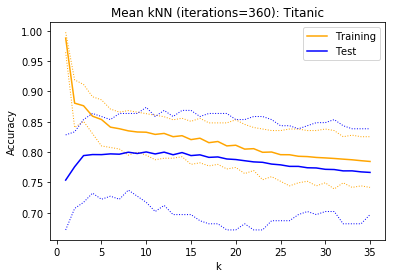

In [36]:
### Plot mean k vs accuracy
kVsAcc_mean = np.mean(kVsAcc, axis=0)
Train_accuracy = kVsAcc_mean[0]
Test_accuracy = kVsAcc_mean[1]

# Generate plot with diffs as "error bands"
plt.figure()
plt.title('Mean kNN (iterations='+str(iters)+'): Titanic')
plt.plot(n, kVsAcc_train_max, color='orange', linewidth=1, linestyle=':')
plt.plot(n, Train_accuracy, label = 'Training', color='orange')
plt.plot(n, kVsAcc_train_min, color='orange', linewidth=1, linestyle=':')
plt.plot(n, kVsAcc_test_max, color='blue', linewidth=1, linestyle=':')
plt.plot(n, Test_accuracy, label = 'Test', color='blue')
plt.plot(n, kVsAcc_test_min, color='blue', linewidth=1, linestyle=':')
plt.legend()
plt.xlabel('k')
plt.ylabel('Accuracy')
#plt.savefig('MeankNN.png')
plt.show(block=False)

The above takes a few minutes to run but look at the cool and generally useless plot! We can see accuracy of the model as a function of chosen k. We split train into effectively another train and test (validation) datasets to determine the accuracy of each k. To deterime k we randomly split the data 360 times. And for each time we determined the accuracy for k=range(0,36). The accuracies for each time were averaged wrt to k, and the ranges found, to determine the optimal k with some "uncertainty" on accuracy. 

In [37]:
### Do final kNN with above-found best k on real test data
# Relabel variables for easier reading again
X_train = train.drop(['Survived'],axis=1)
y_train = train['Survived']
# With some k nearest neighbors, create classifier
k = Test_accuracy.argmax()+1 #test_accuracy.argmax()+1 #6
print('')
print('Optimal k =', k)
kNN = KNeighborsClassifier(n_neighbors=k)#, weights='distance')
# "Fit" the classifier to the data
kNN.fit(X_train, y_train)


Optimal k = 10


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [42]:
### Pass test data (or any data that meets type/form) 
# and have the now-fitted classifier predict targets
prediction = kNN.predict(test.drop('PassengerId', axis=1))
prediction_probs = kNN.predict_proba(test.drop('PassengerId', axis=1))
print(prediction)

[0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0
 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0
 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0
 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0
 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0
 1 0 1 0 1 0 0 1 0 0 0]


In [43]:
### Save prediction to csv for submission
df = pd.DataFrame(data=prediction, index=test['PassengerId'], columns=['Survived'])
df.to_csv('gender_submission.csv', header=True)

When submitted to Kaggle this algorithm only correctly predicts passenger survival with an accuracy of about 60%. This was a bummer because from the above plot I predicted an accuracy of about 80%. Considering that random guessing would be 50% and the best is supposed to be about 85% reliably, solely employing a basic kNN algorithm is probably NOT the way to go.

# <a name="randomforest">Random Forest</a>

I'll admit it: after the horrendous outcome of the kNN above, I decided to see what other submitters employed for this binary classification problem. It seems many (many) people used random forests. After seeing that, and before seeing their implementation, I thought about it and gave it a shot.